# 2D computer vision - Darts game analysis

This notebook is a solution for the 2D computer vision - Darts game analysis. The goal of this competition is to predict the score of a dart game based on the image of the dartboard. For the detailed desscription use README.md file.

In [2]:
#Installing the requirements
%pip install -r /content/requirements.txt

In [6]:
import os
import zipfile
import gdown
import cv2
import shutil
from sklearn.model_selection import train_test_split
import pillow_heif
import math
from IPython.display import display
import torch
import numpy as np
from PIL import Image

## Dataset download

I created my own dataset and loaded it to the disk. The dataset is available for download from the following link below.

In [5]:
url = f'https://drive.google.com/uc?id=1xPajZXKpmtDJWhi4JO2vkycbf2884Dbc'

output = 'darts_dataset.zip'
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1xPajZXKpmtDJWhi4JO2vkycbf2884Dbc
From (redirected): https://drive.google.com/uc?id=1xPajZXKpmtDJWhi4JO2vkycbf2884Dbc&confirm=t&uuid=b9947dd2-7d09-4c71-86a4-bf5210a84df7
To: /content/darts_dataset.zip
100%|██████████| 78.0M/78.0M [00:03<00:00, 21.8MB/s]


'darts_dataset.zip'

In [6]:
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('darts_dataset')

Initializing the directories structures.

In [1]:
images_dir = '/content/darts_dataset/darts_dataset/images'
labels_dir = '/content/darts_dataset/darts_dataset/labels'
train_images_dir = '/content/darts_dataset/darts_dataset/images/train'
val_images_dir = '/content/darts_dataset/darts_dataset/images/val'
train_labels_dir = '/content/darts_dataset/darts_dataset/labels/train'
val_labels_dir = '/content/darts_dataset/darts_dataset/labels/val'

### Split the dataset into train and validation sets

In [8]:
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.txt')])

train_images, val_images, train_labels, val_labels = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42
)

for image in train_images:
    shutil.move(os.path.join(images_dir, image), os.path.join(train_images_dir, image))

for image in val_images:
    shutil.move(os.path.join(images_dir, image), os.path.join(val_images_dir, image))

for label in train_labels:
    shutil.move(os.path.join(labels_dir, label), os.path.join(train_labels_dir, label))

for label in val_labels:
    shutil.move(os.path.join(labels_dir, label), os.path.join(val_labels_dir, label))

print("Dataset organized into training and validation sets.")


Dataset organized into training and validation sets.


### Process the test images

In [9]:
def process_images(input_folder, output_folder):
    pillow_heif.register_heif_opener()

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith('.jpg'):
            input_path = os.path.join(input_folder, filename)
            with Image.open(input_path) as img:
                img = img.convert('RGB')

                # Calculate dimensions to crop the image to 1:1 aspect ratio
                width, height = img.size
                new_dimension = min(width, height)
                left = (width - new_dimension) / 2
                top = (height - new_dimension) / 2
                right = (width + new_dimension) / 2
                bottom = (height + new_dimension) / 2

                img = img.crop((left, top, right, bottom))

                img = img.resize((800, 800), Image.LANCZOS)

                output_path = os.path.join(output_folder, filename.replace('.jpg', '.png'))
                img.save(output_path)
                print(f'Processed and saved: {output_path}')

In [10]:
process_images('/content/darts_dataset/darts_dataset/images/test', '/content/darts_dataset/darts_dataset/images/test')

Processed and saved: /content/darts_dataset/darts_dataset/images/test/IMG_20240510_172837.png
Processed and saved: /content/darts_dataset/darts_dataset/images/test/IMG_20240510_172748.png
Processed and saved: /content/darts_dataset/darts_dataset/images/test/IMG_20240510_172930.png


## Model configuration and training

### Defining the yaml configuration file

In [11]:
yaml_content = f"""
path: {'/content/darts_dataset/darts_dataset'}
train: {os.path.join(images_dir, 'train')}
val: {os.path.join(images_dir, 'val')}
nc: 4
names: ['Board center', 'Dart Point', 'Green Dart', 'Red Dart']
"""
dataset_path = '/content/darts_dataset/darts_dataset'
yaml_path = os.path.join(dataset_path, 'darts.yaml')
with open(yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content.strip())

print(f"Configuration file created at {yaml_path}")


Configuration file created at /content/darts_dataset/darts_dataset/darts.yaml


### Installing the ultralytics and yolov5 

In [12]:
!git clone https://github.com/ultralytics/ultralytics.git
!pip install ultralytics


Cloning into 'ultralytics'...
remote: Enumerating objects: 28729, done.
remote: Counting objects: 100% (1747/1747), done.
remote: Compressing objects: 100% (1156/1156), done.
remote: Total 28729 (delta 1107), reused 994 (delta 586), pack-reused 26982
Receiving objects: 100% (28729/28729), 16.91 MiB | 13.65 MiB/s, done.
Resolving deltas: 100% (20087/20087), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 8.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/

In [ ]:
!git clone https://github.com/ultralytics/yolov5  
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16656, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 16656 (delta 1), reused 5 (delta 0), pack-reused 16649
Receiving objects: 100% (16656/16656), 15.14 MiB | 14.57 MiB/s, done.


### Training the model

For training I decided to use the YOLOv5 model (yolov5s.pt). The model was trained for 200 epochs with the following configuration:
- batch size: 16
- image size: 800x800

In [2]:
!python /content/yolov5/train.py --data coco.yaml --batch-size 16 --epochs 200 --data /content/darts_dataset/darts_dataset/darts.yaml --img 800 --weights yolov5s.pt

  Using cached ultralytics-8.2.28-py3-none-any.whl (779 kB)
  Using cached ultralytics_thop-0.2.7-py3-none-any.whl (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using ca

### The model achieved the following results (more details can be found in the images folder):

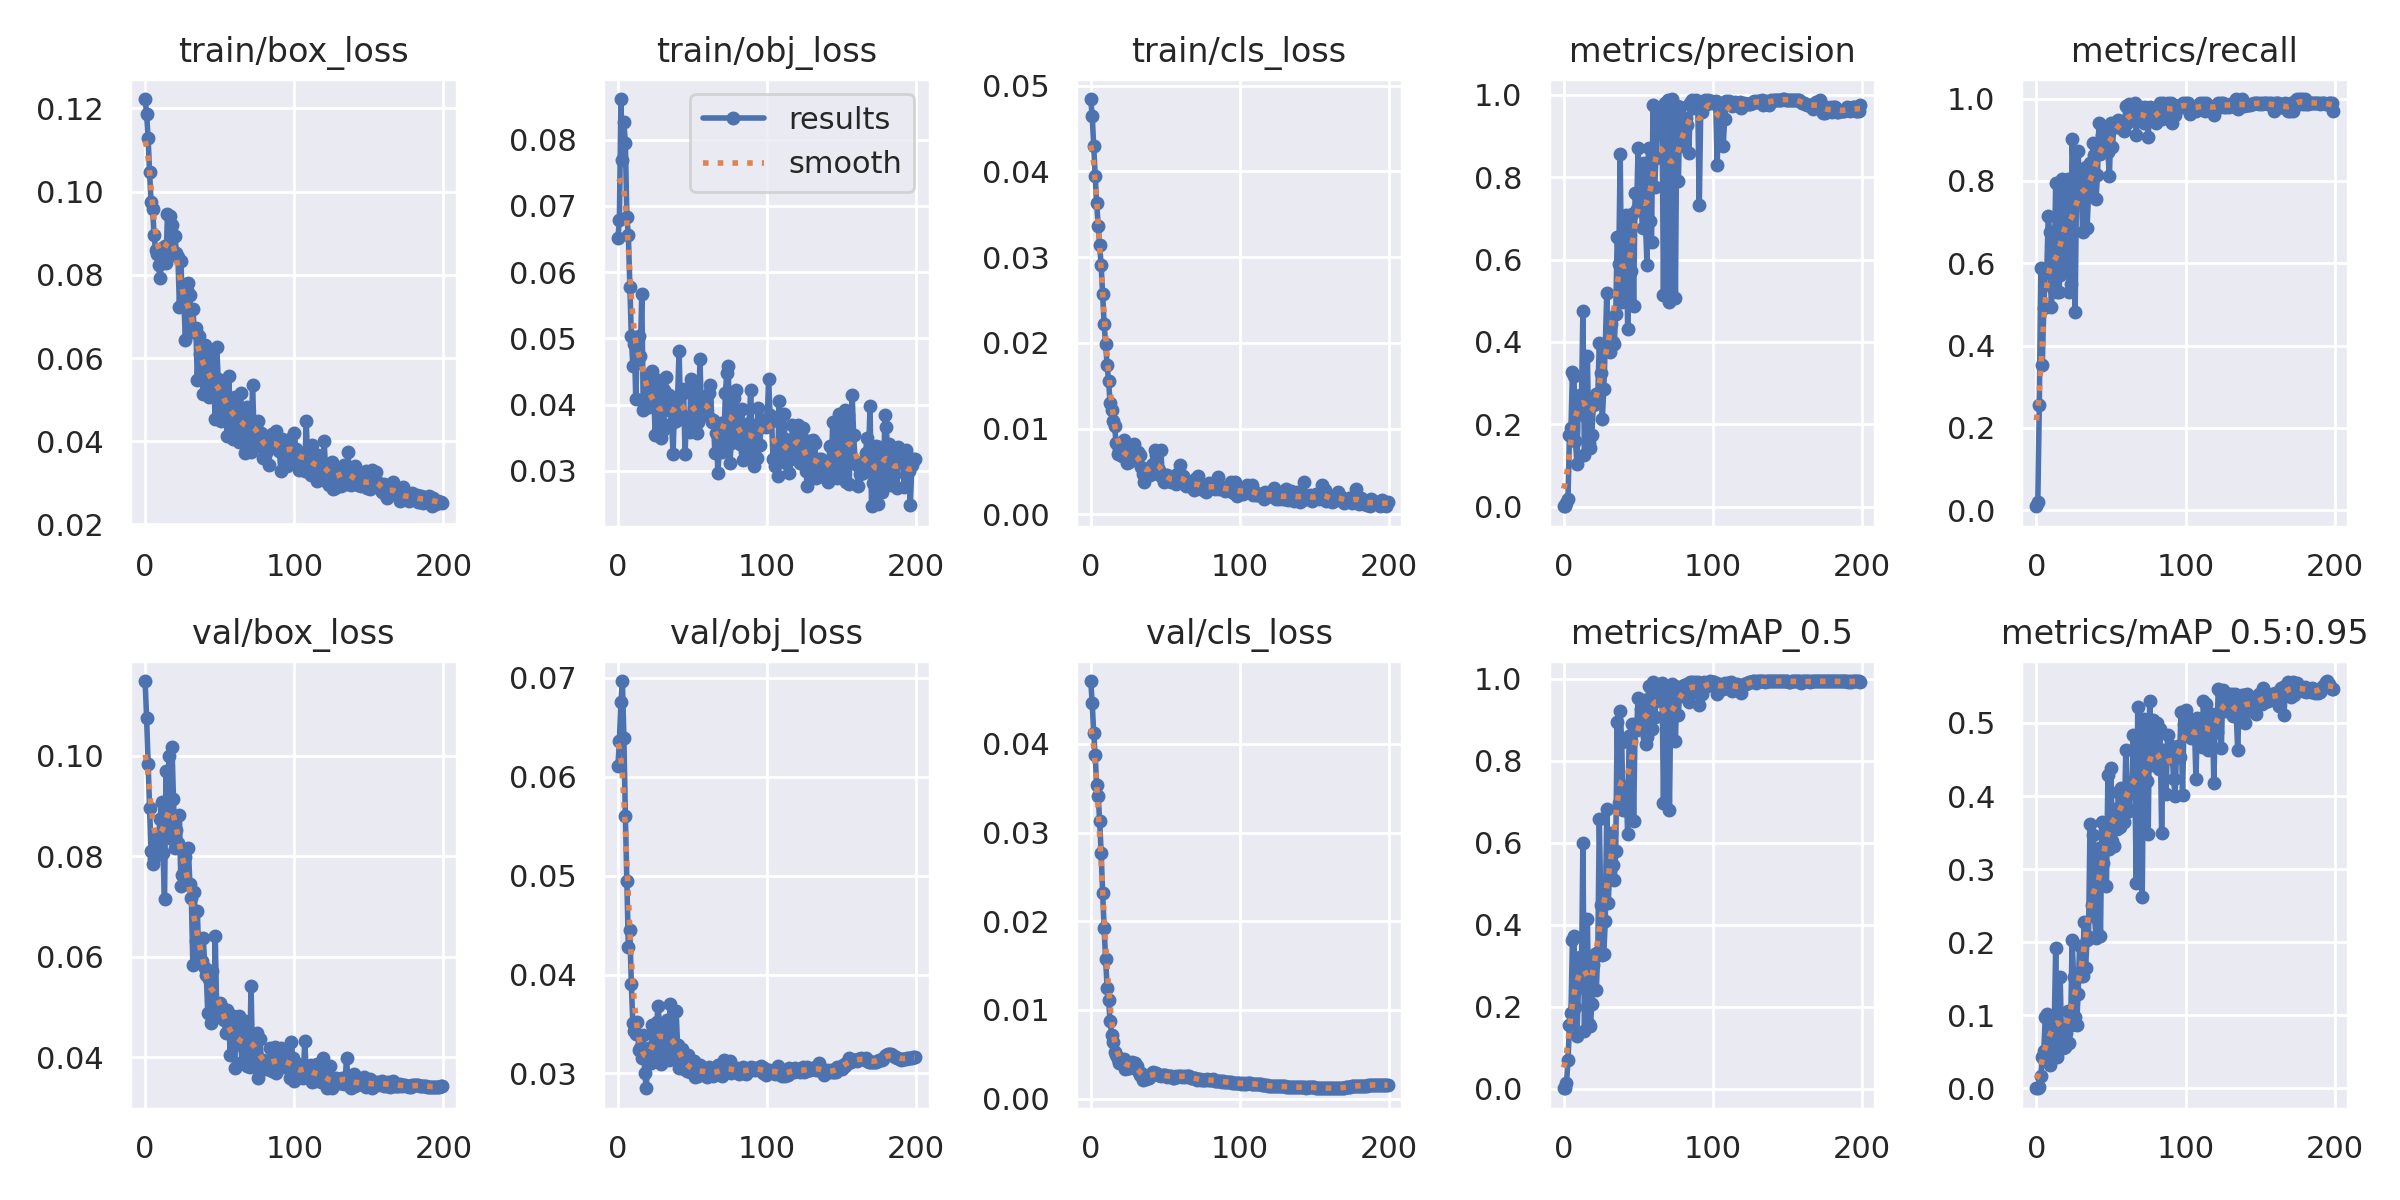
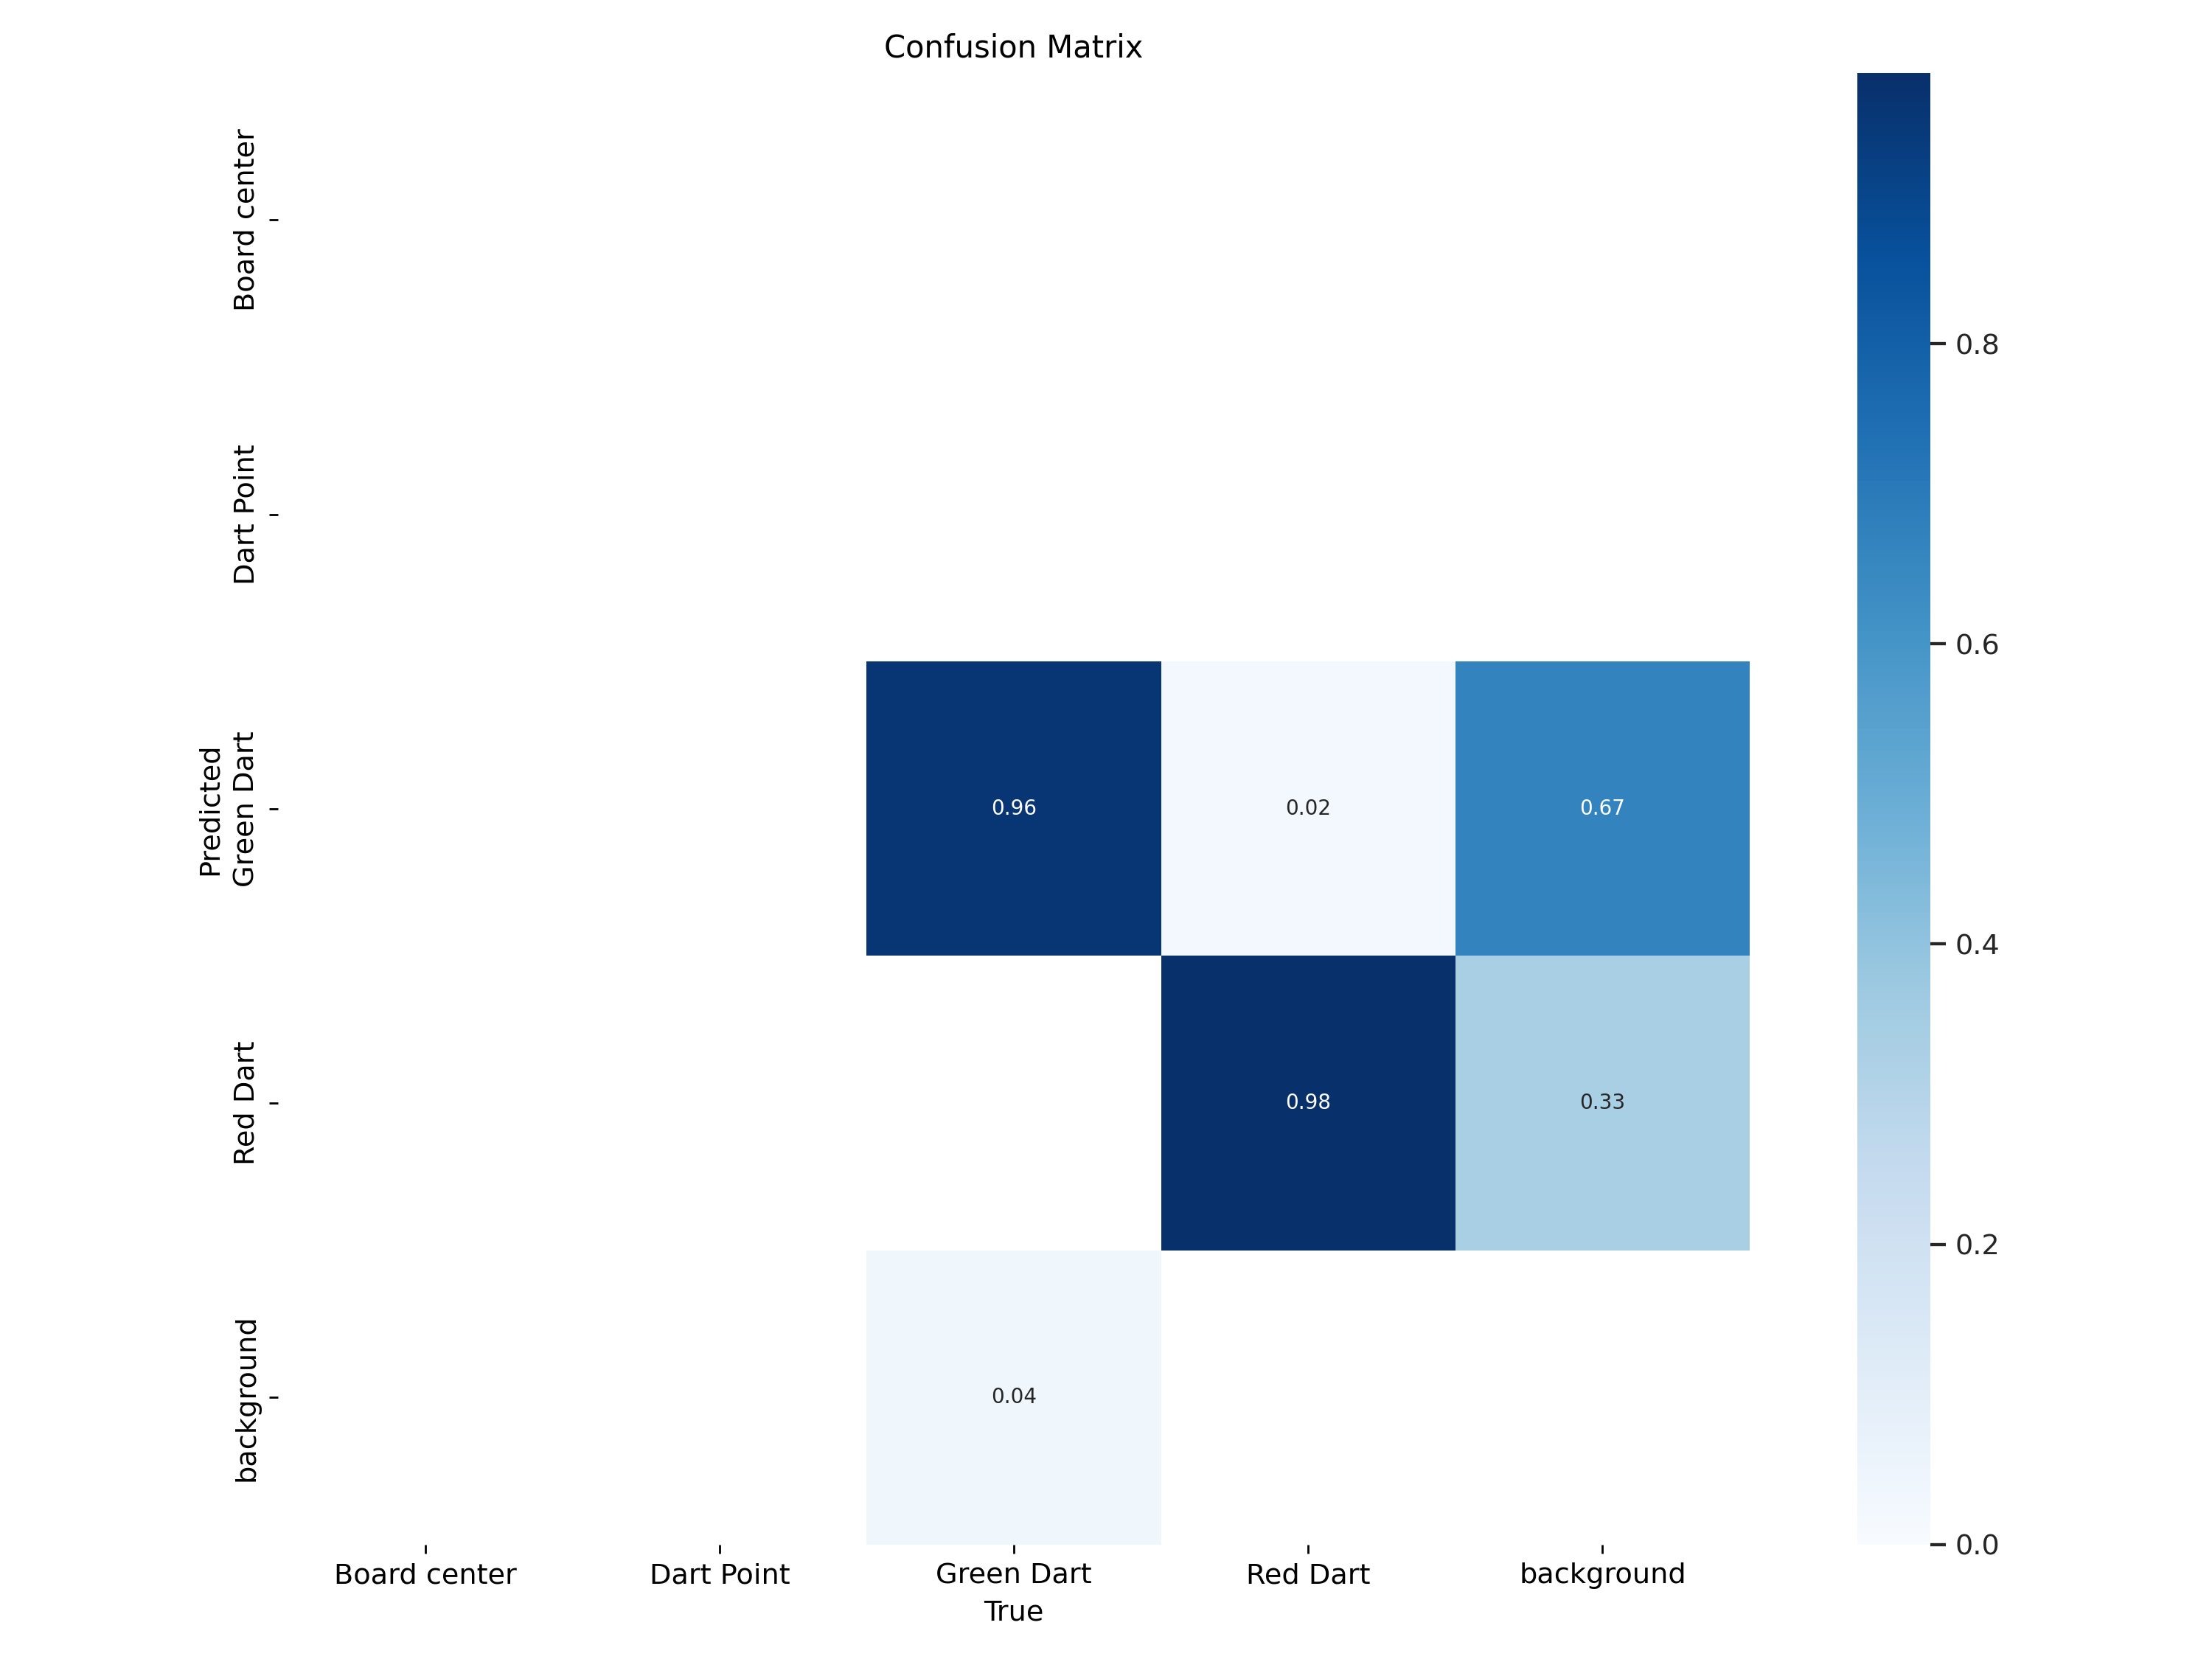

### Analyzing the board

The next function is used to find the outer circle of the dartboard, its center and radious for future scoring. All founded circles are then fittered to find the most fitting one.

In [3]:

def get_board_center_and_radius(image_path):

    image = cv2.imread(image_path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
                               param1=50, param2=30, minRadius=0, maxRadius=0)

    height, width = image.shape[:2]

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")

        largest_circle = None
        max_diameter = 0

        for (x, y, r) in circles:
            diameter = 2 * r
            if diameter > 400 and x - r > 0 and x + r < width and y - r > 0 and y + r < height:
                if diameter > max_diameter:
                    max_diameter = diameter
                    largest_circle = (x, y, r)

        if largest_circle is not None:
            x, y, r = largest_circle
            return (x, y, r)
    return None



### Scoring system

Scoring is performed by calculating the euclidean distance between the center of the dartboard and the center of the dart bound box.

In [4]:
scoring_zones = {
    'bullseye': 100,
    'ring1': 80,
    'ring2': 60,
    'ring3': 50,
    'ring4': 40,
    'ring5': 30,
    'ring6': 20,
    'ring7': 10,
    'outer': 0
}

def calculate_score(x_center, y_center, board_center):
    x_board_center, y_board_center, r_b = board_center

    # Calculate the distance from the dart center to the board center
    distance = math.sqrt((x_center - x_board_center) ** 2 + (y_center - y_board_center) ** 2)

    radiuses = [0.1*r_b, 0.2*r_b, 0.34*r_b, 0.48*r_b, 0.6*r_b, 0.72*r_b, 0.86*r_b, r_b]

    if distance <= radiuses[0]:
        return scoring_zones['bullseye']
    elif distance <= radiuses[1]:
        return scoring_zones['ring1']
    elif distance <= radiuses[2]:
        return scoring_zones['ring2']
    elif distance <= radiuses[3]:
        return scoring_zones['ring3']
    elif distance <= radiuses[4]:
        return scoring_zones['ring4']
    elif distance <= radiuses[5]:
        return scoring_zones['ring5']
    elif distance <= radiuses[6]:
        return scoring_zones['ring6']
    elif distance <= radiuses[7]:
        return scoring_zones['ring7']
    else:
        return scoring_zones['outer']


### Testing the model

The best model is loaded and then function for processing the image is used to calculate the scores for each dart color.

In [7]:

# Load the trained YOLOv5 model
model_name = '/content/yolov5/runs/train/exp/weights/best.pt'
model = torch.hub.load('/content/yolov5/', 'custom', source='local', path=model_name, force_reload=True)

# Directory containing test images
test_folder = '/content/darts_dataset/darts_dataset/images/test'
result_folder = '/content/darts_dataset/darts_dataset/images/results'

# Function to process a single image
def process_image(image_path):
    results = model(image_path)
    # Example usage
    board = get_board_center_and_radius(image_path)

    # Extract bounding boxes and scores
    image = cv2.imread(image_path)

    green_score = 0
    red_score = 0

    for bbox in results.xywh[0].cpu().numpy():  # Move tensor to CPU before converting to numpy
        x_center, y_center, width, height, confidence, class_id = bbox
        x = int(x_center - width / 2)
        y = int(y_center - height / 2)
        w = int(width)
        h = int(height)
        label = 'Green Dart' if class_id == 2 else 'Red Dart'

        # Draw the bounding box
        color = (0, 255, 0) if class_id == 2 else (0, 0, 255)
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

        # Put label and confidence on the bounding box
        text = f'{label} {confidence:.2f}'
        cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Calculate the score for each dart
        score = calculate_score(x_center, y_center, board)
        print(f'{label} at ({x_center}, {y_center}), Score: {score}')

        # Accumulate scores based on dart color
        if class_id == 2:
            green_score += score
        else:
            red_score += score

    # Save the image with bounding boxes
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)
    output_path = os.path.join(result_folder, os.path.basename(image_path).replace('.jpg', '_with_boxes.jpg'))
    cv2.imwrite(output_path, image)
    print(f'Saved image with bounding boxes to {output_path}')

    return green_score, red_score


YOLOv5 🚀 v7.0-318-gc0380fd8 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


## Test results

The model showed excellent results with founding the darts, but the scoring is not quite accurate because the dart bound box center not always corresponds to the tip of the dart. The model can be improved by using the more complex way to find the exact tip of the dart.

WARNING ⚠️ NMS time limit 0.550s exceeded


Green Dart at (528.60546875, 237.20791625976562), Score: 30
Red Dart at (411.4908752441406, 410.5865783691406), Score: 100
Red Dart at (509.39996337890625, 444.8893737792969), Score: 60
Red Dart at (527.6822509765625, 418.1504821777344), Score: 60
Green Dart at (393.4159851074219, 543.5674438476562), Score: 50
Green Dart at (406.5543212890625, 584.637451171875), Score: 40
Saved image with bounding boxes to /content/darts_dataset/darts_dataset/images/results/IMG_20240510_172930.png
Winner: Red with 220 points
Looser: Green with 120 points


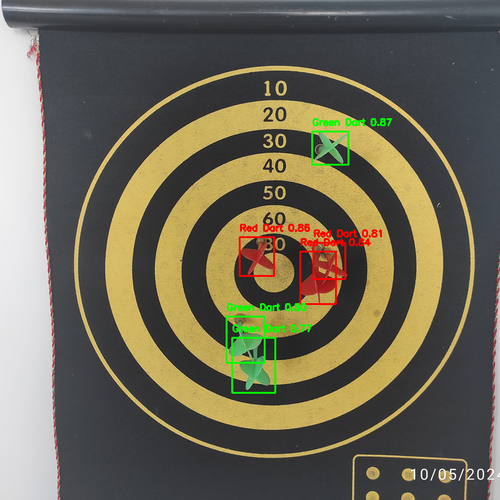

Green Dart at (491.50299072265625, 165.329833984375), Score: 20
Green Dart at (476.3471984863281, 553.4069213867188), Score: 30
Red Dart at (490.9635314941406, 411.0869140625), Score: 60
Red Dart at (324.121337890625, 440.6268005371094), Score: 40
Red Dart at (655.568359375, 414.17877197265625), Score: 20
Green Dart at (138.19549560546875, 335.0322265625), Score: 0
Saved image with bounding boxes to /content/darts_dataset/darts_dataset/images/results/IMG_20240510_172837.png
Winner: Red with 120 points
Looser: Green with 50 points


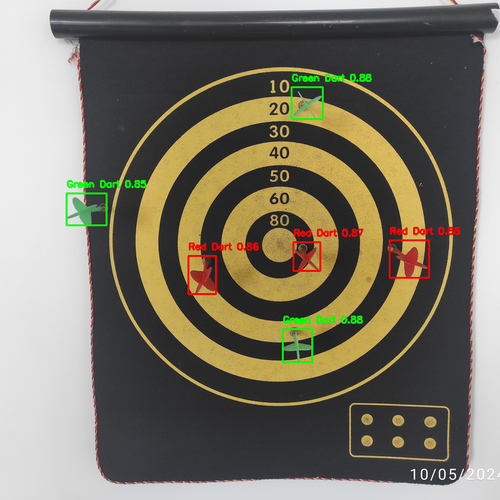

Green Dart at (415.496826171875, 354.494140625), Score: 60
Red Dart at (488.9759521484375, 398.183837890625), Score: 60
Green Dart at (334.4204406738281, 470.9403076171875), Score: 50
Green Dart at (639.5606079101562, 460.3977966308594), Score: 20
Red Dart at (331.4198303222656, 504.41021728515625), Score: 40
Red Dart at (479.917236328125, 480.4835205078125), Score: 60
Saved image with bounding boxes to /content/darts_dataset/darts_dataset/images/results/IMG_20240510_172748.png
Winner: Red with 160 points
Looser: Green with 130 points


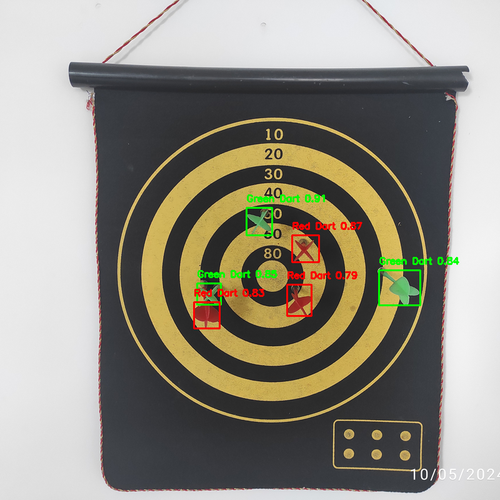

In [8]:

for image_name in os.listdir(test_folder):
    total_green_score = 0
    total_red_score = 0
    if image_name.endswith('.png'):
        image_path = os.path.join(test_folder, image_name)
        green_score, red_score = process_image(image_path)
        total_green_score += green_score
        total_red_score += red_score

        # Determine the winner
        if total_green_score > total_red_score:
            print(f'Winner: Green with {total_green_score} points\nLooser: Red with {total_red_score} points')
        elif total_red_score > total_green_score:
            print(f'Winner: Red with {total_red_score} points\nLooser: Green with {total_green_score} points')
        else:
            print('It\'s a tie!')

        result_img = os.path.join(result_folder, os.path.basename(image_path).replace('.jpg', '_with_boxes.jpg'))
        img = Image.open(result_img)

        # Resize image
        new_size = (500, 500)  # Width, Height
        img_resized = img.resize(new_size, Image.LANCZOS)

        # Display resized image
        display(img_resized)
